# TorchVision Object Detection Finetuning Tutoria

For this tutorial, we will be finetuning a pre-trained Mask R-CNN model on the Penn-Fudan Database for Pedestrian Detection and Segmentation. It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an object detection and instance segmentation model on a custom dataset.

This tutorial works only with torchvision version >=0.16 or nightly. If you’re using torchvision<=0.15, please follow this tutorial instead.

## Defining the Dataset

The reference scripts for training object detection, instance segmentation and person keypoint detection allows for easily supporting adding new custom datasets. The dataset should inherit from the standard torch.utils.data.Dataset class, and implement __len__ and __getitem__.

The only specificity that we require is that the dataset __getitem__ should return a tuple:

    image: torchvision.tv_tensors.Image of shape [3, H, W], a pure tensor, or a PIL Image of size (H, W)

    target: a dict containing the following fields

        boxes, torchvision.tv_tensors.BoundingBoxes of shape [N, 4]: the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H

        labels, integer torch.Tensor of shape [N]: the label for each bounding box. 0 represents always the background class.

        image_id, int: an image identifier. It should be unique between all the images in the dataset, and is used during evaluation

        area, float torch.Tensor of shape [N]: the area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
        
        iscrowd, uint8 torch.Tensor of shape [N]: instances with iscrowd=True will be ignored during evaluation.
        
        (optionally) masks, torchvision.tv_tensors.Mask of shape [N, H, W]: the segmentation masks for each one of the objects

If your dataset is compliant with above requirements then it will work for both training and evaluation codes from the reference script. Evaluation code will use scripts from pycocotools which can be installed with pip install pycocotools.

In [1]:
#!pip install pycocotools

One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1, 2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratios), then it is recommended to also implement a get_height_and_width method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via __getitem__ , which loads the image in memory and is slower than if a custom method is provided.

## Writing a custom dataset for PennFudan
Let’s write a dataset for the PennFudan dataset. First, let’s download the dataset and extract the zip file:

In [2]:
#!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
#!cd data && unzip PennFudanPed.zip

We have the following folder structure:

    PennFudanPed/
      PedMasks/
        FudanPed00001_mask.png
        FudanPed00002_mask.png
        FudanPed00003_mask.png
        FudanPed00004_mask.png
        ...
      PNGImages/
        FudanPed00001.png
        FudanPed00002.png
        FudanPed00003.png
        FudanPed00004.png

Here is one example of a pair of images and segmentation masks

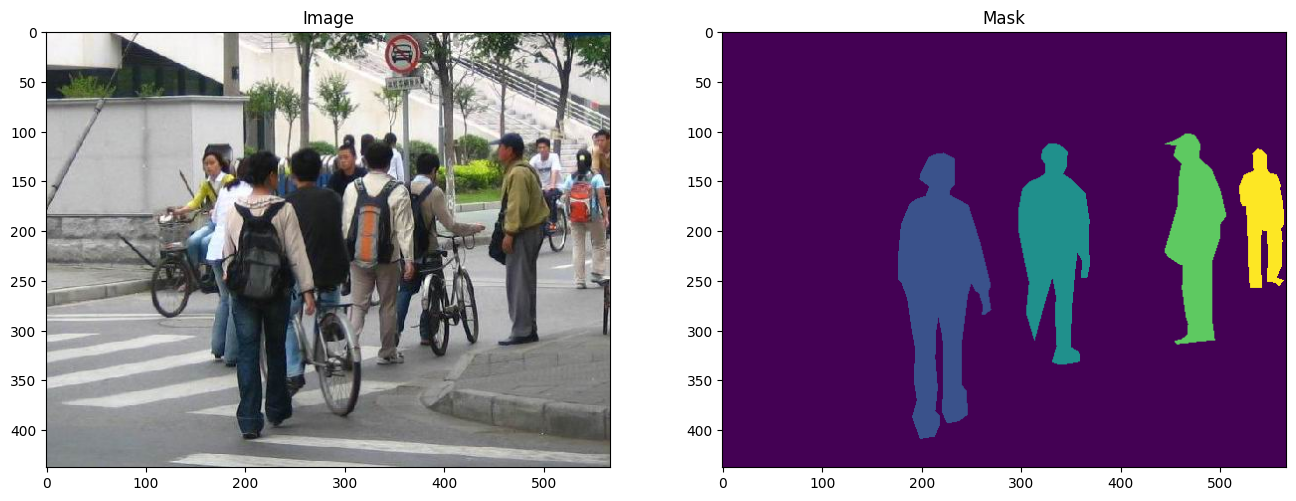

In [3]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let’s write a torch.utils.data.Dataset class for this dataset. In the code below, we are wrapping images, bounding boxes and masks into torchvision.tv_tensors.TVTensor classes so that we will be able to apply torchvision built-in transformations (new Transforms API) for the given object detection and segmentation task. Namely, image tensors will be wrapped by torchvision.tv_tensors.Image, bounding boxes into torchvision.tv_tensors.BoundingBoxes and masks into torchvision.tv_tensors.Mask. As torchvision.tv_tensors.TVTensor are torch.Tensor subclasses, wrapped objects are also tensors and inherit the plain torch.Tensor API. For more information about torchvision tv_tensors see this documentation.

In [4]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That’s all for the dataset. Now let’s define a model that can perform predictions on this dataset.

## Defining your model 

In this tutorial, we will be using Mask R-CNN, which is based on top of Faster R-CNN. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image

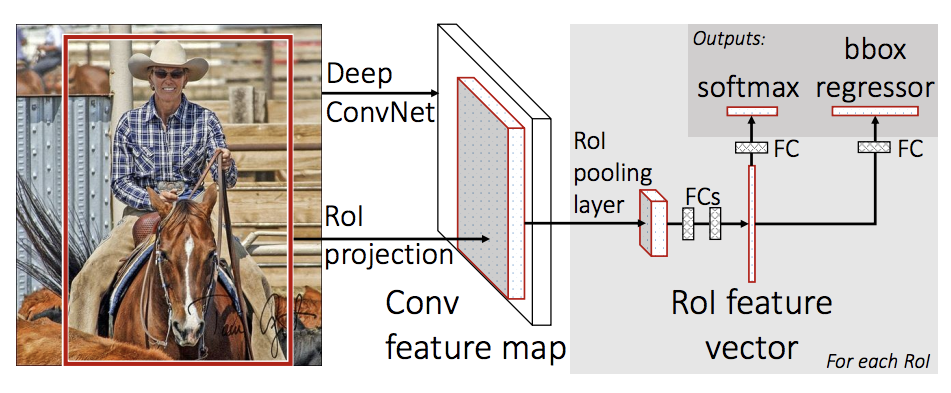

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

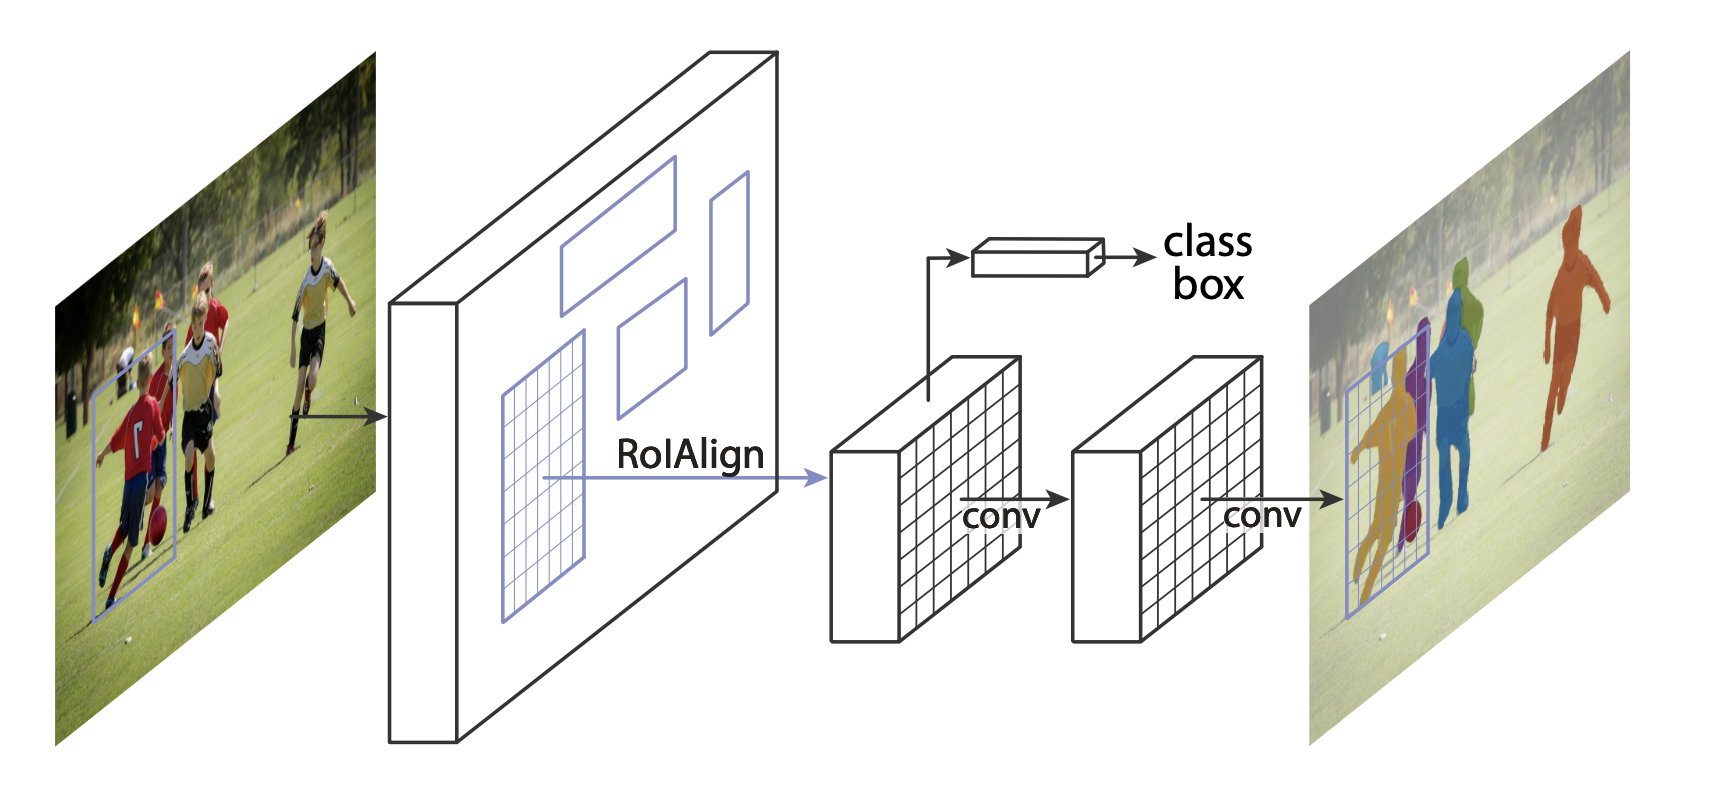

There are two common situations where one might want to modify one of the available models in TorchVision Model Zoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let’s go see how we would do one or another in the following sections.

## 1 - Finetuning from a pretrained model
Let’s suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## 2 - Modifying the model to add a different backbone

In [6]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

## Object detection and instance segmentation model for PennFudan Dataset
In our case, we want to finetune from a pre-trained model, given that our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:



In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

Putting everything together
In references/detection/, we have a number of helper functions to simplify training and evaluating detection models. Here, we will use references/detection/engine.py and references/detection/utils.py. Just download everything under references/detection to your folder and use them here. On Linux if you have wget, you can download them using below commands:



In [8]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2025-10-31 18:26:42--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py’

     0K ...                                                   100% 2.13M=0.002s

2025-10-31 18:26:42 (2.13 MB/s) - ‘engine.py’ saved [4063/4063]

--2025-10-31 18:26:42--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

0

Since v0.15.0 torchvision provides new Transforms API to easily write data augmentation pipelines for Object Detection and Segmentation tasks.

Let’s write some helper functions for data augmentation / transformation:

In [9]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)